# Imports and loads

In [52]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping
import glob

warnings.filterwarnings('ignore')

In [4]:
# # Caminho onde os arquivos CSV estão localizados
# path = './'  # Altere para o diretório correto onde os arquivos estão localizados
# all_files = glob.glob(path + "data_live_scores*.csv")

# # Lista para armazenar os dataframes
# df_list = []

# # Ler cada arquivo CSV e adicionar à lista
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     df_list.append(df)

# # Concatenar todos os dataframes na lista
# combined_csv = pd.concat(df_list, axis=0, ignore_index=True)

# # Salvar o dataframe combinado em um arquivo CSV
# combined_csv.to_csv("data_live_scores.csv", index=False)


In [64]:
# df05ht = pd.read_csv('../data/raw/data_live_scores.csv').reset_index(drop=True)
df05ht = pd.read_csv('data_live_scores.csv')
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2023-08-20,0:53,Aston Villa FC,Everton FC,England - Premier League,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
1,2023-08-20,2:00,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
2,2023-08-20,3:07,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
3,2023-08-20,4:13,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
4,2023-08-20,5:20,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209956,2023-03-25,38:22,Charlotte FC,New York Red Bulls,USA - MLS,2.0,1.0,0.0,0.0,0.0,...,6.0,7.0,7.0,6.0,0.0,0.0,6.0,4.0,1.0,2023-03-25-Charlotte FC-New York Red Bulls
209957,2023-03-25,39:15,Charlotte FC,New York Red Bulls,USA - MLS,2.0,1.0,0.0,0.0,0.0,...,7.0,7.0,7.0,7.0,0.0,0.0,6.0,4.0,1.0,2023-03-25-Charlotte FC-New York Red Bulls
209958,2023-03-25,40:09,Charlotte FC,New York Red Bulls,USA - MLS,2.0,1.0,0.0,0.0,0.0,...,7.0,7.0,7.0,7.0,0.0,0.0,6.0,4.0,1.0,2023-03-25-Charlotte FC-New York Red Bulls
209959,2023-03-25,41:03,Charlotte FC,New York Red Bulls,USA - MLS,2.0,1.0,0.0,0.0,0.0,...,7.0,7.0,7.0,7.0,0.0,0.0,6.0,4.0,1.0,2023-03-25-Charlotte FC-New York Red Bulls


In [54]:
# drop Unnamed: 0
# df05ht.drop('Unnamed: 0', axis=1, inplace=True)
df05ht.dropna(inplace=True)
df05ht.drop_duplicates(inplace=True)
df05ht.reset_index(drop=True, inplace=True)
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2023-08-20,0:36,Aston Villa FC,Everton FC,England - Premier League,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,2023-08-20,0:53,Aston Villa FC,Everton FC,England - Premier League,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
2,2023-08-20,2:00,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
3,2023-08-20,3:07,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
4,2023-08-20,4:13,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210019,2023-03-24,30:31,2023-03-24-Sweden-Belgium,Sweden,Belgium,Europe - UEFA European Championship Qualifiers,2.0,5.0,0.0,0.0,...,180.0,1.0,2.0,2.0,1.0,0.0,0.0,9.0,4.0,1
210020,2023-03-24,31:22,2023-03-24-Sweden-Belgium,Sweden,Belgium,Europe - UEFA European Championship Qualifiers,2.0,5.0,0.0,0.0,...,182.0,1.0,2.0,2.0,1.0,0.0,0.0,9.0,4.0,1
210021,2023-03-24,32:13,2023-03-24-Sweden-Belgium,Sweden,Belgium,Europe - UEFA European Championship Qualifiers,2.0,5.0,0.0,0.0,...,190.0,2.0,2.0,2.0,2.0,0.0,0.0,9.0,4.0,1
210022,2023-03-24,33:04,2023-03-24-Sweden-Belgium,Sweden,Belgium,Europe - UEFA European Championship Qualifiers,2.0,5.0,0.0,0.0,...,203.0,2.0,2.0,2.0,2.0,0.0,0.0,9.0,4.0,1


In [63]:
# df05ht = df05ht[df05ht['match_id'] != '1']
# df05ht = df05ht[df05ht['match_id'] != '0']
# df05ht = df05ht[df05ht['match_id'] != ' ']
# df05ht.to_csv('data_live_scores.csv', index=False)

In [7]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

In [8]:
df05ht.to_csv('data_live_scores.csv', index=False)

# Preprocess

In [9]:
df05ht['possessiontime_away'] = (df05ht['passes_away'] / (df05ht['passes_away'] + df05ht['passes_home'])) * 100
df05ht['possessiontime_home'] = (df05ht['passes_home'] / (df05ht['passes_away'] + df05ht['passes_home'])) * 100


In [10]:
new_columns_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df05ht = df05ht.rename(columns=new_columns_names)

In [11]:
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,2023-08-20,0:36,Aston Villa FC,Everton FC,England - Premier League,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,50.000000,50.000000
1,2023-08-20,0:53,Aston Villa FC,Everton FC,England - Premier League,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC,0.000000,100.000000
2,2023-08-20,2:00,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC,6.666667,93.333333
3,2023-08-20,3:07,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC,38.709677,61.290323
4,2023-08-20,4:13,Aston Villa FC,Everton FC,England - Premier League,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-20-Aston Villa FC-Everton FC,26.530612,73.469388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209959,2023-03-24,6:35,Gibraltar,Greece,Europe - UEFA European Championship Qualifiers,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2023-03-24-Gibraltar-Greece,73.333333,26.666667
209960,2023-03-24,7:25,Gibraltar,Greece,Europe - UEFA European Championship Qualifiers,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2023-03-24-Gibraltar-Greece,72.000000,28.000000
209961,2023-03-24,8:16,Gibraltar,Greece,Europe - UEFA European Championship Qualifiers,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2023-03-24-Gibraltar-Greece,72.619048,27.380952
209962,2023-03-24,9:07,Gibraltar,Greece,Europe - UEFA European Championship Qualifiers,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,1.0,2023-03-24-Gibraltar-Greece,73.404255,26.595745


In [12]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')

In [13]:
df05ht.drop(columns=["date",'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away'], inplace=True)

In [14]:
leagues_opta = df05ht['league'].unique()

In [15]:
for league in leagues_opta:
    print(league)

England - Premier League
Germany - Bundesliga
Spain - Primera División
France - Ligue 1
USA - MLS
Italy - Serie A
Brazil - Serie A
Netherlands - Eredivisie
Romania - Liga I
World - FIFA Women's World Cup
England - Championship
Portugal - Primeira Liga
Europe - UEFA Europa Conference League
England - League Cup
Europe - UEFA Super Cup
Europe - UEFA Champions League
England - League One
England - League Two
Germany - DFB Pokal
Italy - Coppa Italia
Scotland - Premiership
South America - CONMEBOL Libertadores
Argentina - Liga Profesional Argentina
Brazil - Paulista A1
England - Community Shield
N/C America - Concacaf Gold Cup
Europe - UEFA U21 Championship
Romania - Supercupa
Romania - Play-offs 1/2
Australia - A-League Men
Portugal - Play-offs 1/2
Europe - UEFA European Championship Qualifiers
Germany - Play-offs 1/2
Europe - UEFA Nations League
Europe - UEFA Europa League
Brazil - Copa do Brasil
Denmark - Superliga
Mexico - Liga MX
England - FA Cup
Spain - Copa del Rey
World - FIFA World

In [16]:
# df[df['league'] == "Europe - UEFA European Championship Qualifiers"].tail(1)
# 'Australia - A-League Men': 'Australia - A-League',

In [17]:
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Romania - Supercupa': 'Romania - Super Cup',
    'Romania - Play-offs 1/2': 'Romania - Liga 1 - Play-offs',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',

}

print(len(name_mapping))
print(len(leagues_opta))

# Atualize os nomes das ligas em df05ht
df05ht['league'] = df05ht['league'].replace(name_mapping)


41
58


In [18]:
# # Define a variável alvo
target = 'result'

print(len(df05ht['match_id'].unique()))
print(df05ht['result'].value_counts())
print(len(df05ht))

6228
0.0    169877
1.0     40087
Name: result, dtype: int64
209964


In [19]:
df05ht.shape

(209964, 24)

In [20]:
def convert_to_int_minutes(value):
    if '+' in value:
        # Separando o tempo base e o acréscimo
        base_time, added_time = value.split('+')
        added_minutes = int(added_time.split(':')[0])  # Ignorando os segundos, pegando apenas os minutos do acréscimo
    else:
        base_time = value
        added_minutes = 0
    
    # Convertendo o tempo base em minutos
    base_minutes = int(base_time.split(':')[0]) if ':' in base_time else int(base_time)
    
    # Somando os minutos
    total_minutes = base_minutes + added_minutes
    return total_minutes


# Aplicando a função para converter os minutos
df05ht['minute'] = df05ht['minute'].apply(convert_to_int_minutes)

In [21]:
len(df05ht['match_id'].unique())

6228

In [22]:
# 1. Identify leagues with only one unique value in 'result' column
single_value_leagues = df05ht.groupby('league').apply(lambda x: len(x['result'].unique()) == 1)

# 2. Identify leagues with fewer than 100 matches
few_matches_leagues = df05ht['league'].value_counts()
few_matches_leagues = few_matches_leagues[few_matches_leagues < 100].index.tolist()

# Combine the lists of leagues to drop
leagues_to_drop = single_value_leagues[single_value_leagues].index.tolist() + few_matches_leagues

# Drop the identified leagues
filtered_data = df05ht[~df05ht['league'].isin(leagues_to_drop)]

# 3. Balance the 'result' column for each remaining league
balanced_data = []
for league in filtered_data['league'].unique():
    league_data = filtered_data[filtered_data['league'] == league]
    min_count = league_data['result'].value_counts().min()
    
    # Sample 'min_count' examples from each result value
    balanced_samples = [league_data[league_data['result'] == result_val].sample(min_count, random_state=42) for result_val in [0, 1]]
    balanced_data.extend(balanced_samples)

# Combine the balanced data samples
balanced_data = pd.concat(balanced_data, axis=0)
balanced_data.dropna(inplace=True)

# Display the first few rows of the balanced data and the list of dropped leagues
leagues_to_drop


['England - Community Shield',
 'Germany - Bundesliga Play-offs',
 'Italy - Super Cup',
 'Romania - Super Cup',
 'South America - CONMEBOL Recopa',
 'South America - CONMEBOL Recopa',
 'World - FIFA Club World Cup',
 'Romania - Liga 1 - Play-offs',
 'Spain - Super Cup',
 'Europe - UEFA World Cup Qualifiers',
 'Portugal - Primeira Liga - Play-offs',
 'England - Community Shield',
 'Romania - Super Cup',
 'Europe - Uefa Super Cup',
 'Brazil - Supercopa do Brasil',
 'France - Trophée des Champions',
 'Italy - Super Cup',
 'Germany - Bundesliga Play-offs']

In [23]:
df = balanced_data.copy()
df.shape

(79789, 24)

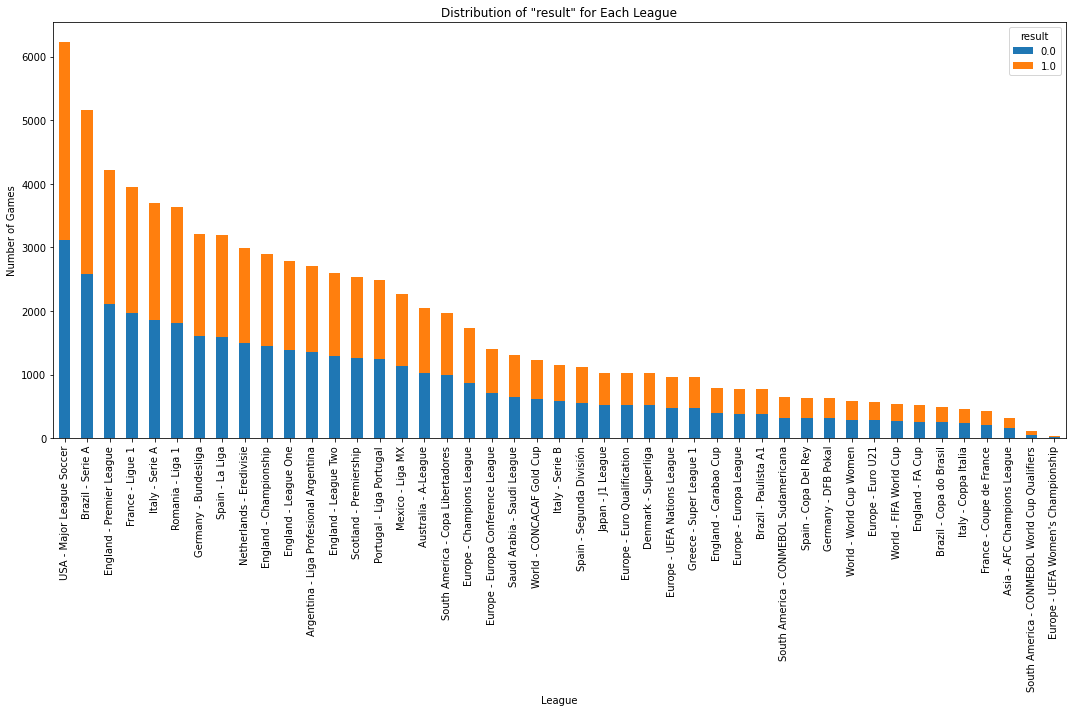

In [24]:
# Group the data by league and result and get the size of each group
league_distribution = df.groupby(['league', 'result']).size().unstack().fillna(0)

# Sort the leagues based on the total number of games
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

# Plot
plt.figure(figsize=(15, 10))
league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of "result" for Each League')
plt.ylabel('Number of Games')
plt.xlabel('League')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


In [25]:
df['result'].value_counts()

1.0    39898
0.0    39891
Name: result, dtype: int64

In [26]:
df.shape

(79789, 24)

In [30]:
df = df.sort_values('minute').reset_index(drop=True)
df.to_csv('data_live_scores_balanced.csv', index=False)
# df = pd.read_csv('data_live_scores_balanced.csv')
# df = pd.read_csv('data_live_scores.csv')

In [28]:
# # IDs únicos no DataFrame
# unique_ids = df['match_id'].unique()

# invalid_ids = []

# for game_id in unique_ids:
#     # Obtenha as minutagens para o ID atual
#     game_df = df[df['match_id'] == game_id]
    
#     # Verifique se há minutos fora do intervalo permitido (maior que 57)
#     if any(game_df['minute'] > 57):
#         invalid_ids.append(game_id)
#         continue  # Pode pular para o próximo ID já que este é inválido
    
# # Remova os IDs inválidos do DataFrame original
# df_clean = df[~df['match_id'].isin(invalid_ids)]

In [29]:
# print(df_clean.shape)
# print(df.shape)

(79732, 24)
(79789, 24)


In [38]:
# df.to_csv("data_live_scores_clean.csv", index=False)

In [39]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')

In [42]:
# Separando os dados em características e variável alvo
X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
y = df['result']

# Definindo as colunas numéricas e categóricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = ['league']

# Criando o transformador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Aplicando as transformações
X = preprocessor.fit_transform(X)

with open(f'../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,train_size=0.80, random_state=42)

# Modeling

## Automl h2o

In [ ]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["col_" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["col_" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

# Run AutoML
aml = H2OAutoML(max_models=20, seed=42)
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

In [ ]:
loaded_model = h2o.load_model("C:/Users/Pichau/Desktop/eofut/models/StackedEnsemble_AllModels_1_AutoML_1_20230923_153346")
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# In pratice

In [ ]:
h2o.init()
loaded_model = h2o.load_model("C:/Users/Pichau/Desktop/eo-fut-live/models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 22 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,30 days
H2O_cluster_name:,H2O_from_python_Pichau_eas44d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.820 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.589734,0.410266


In [ ]:
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.410265916561806

## Random Forest

In [39]:
# teste com random forest foi feito mas não atingiu uma boa espectativa 
# # Criando o modelo base
# rfc = RandomForestClassifier(n_estimators=1000,max_depth=40, min_samples_leaf=1, min_samples_split=30, max_features=None, random_state=1, n_jobs=-1)

# import accuracy_score
from sklearn.metrics import accuracy_score



rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # # Treinando o modelo com os melhores hiperparâmetros
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)


print(f" Teste Acurácia do modelo Random Forest: {accuracy * 100:.2f}%")
print(f"Erro quadrático médio: {mean_squared_error(y_test, predictions)}")
print(f"Treino Acurácia do modelo Random Forest: {rfc.score(X_train, y_train) * 100:.2f}%")

with open(f'random_forestht.pkl', 'wb') as f:
    pickle.dump(rfc, f)

 Teste Acurácia do modelo Random Forest: 73.49%
Erro quadrático médio: 0.26513347537285376
Treino Acurácia do modelo Random Forest: 92.95%


## Neural Network Keras

In [46]:
X_train = X_train.toarray()
X_test = X_test.toarray()



Epoch 1/500
998/998 [==============================] - 2s 2ms/step - loss: 0.6861 - accuracy: 0.5399 - precision: 0.5360 - recall: 0.5794 - val_loss: 0.6839 - val_accuracy: 0.5557 - val_precision: 0.5418 - val_recall: 0.7737
Epoch 2/500
998/998 [==============================] - 1s 1ms/step - loss: 0.6727 - accuracy: 0.5718 - precision: 0.5639 - recall: 0.6259 - val_loss: 0.6722 - val_accuracy: 0.5743 - val_precision: 0.5874 - val_recall: 0.5248
Epoch 3/500
998/998 [==============================] - 1s 1ms/step - loss: 0.6565 - accuracy: 0.6012 - precision: 0.5932 - recall: 0.6386 - val_loss: 0.6648 - val_accuracy: 0.5909 - val_precision: 0.6062 - val_recall: 0.5396
Epoch 4/500
998/998 [==============================] - 1s 1ms/step - loss: 0.6391 - accuracy: 0.6254 - precision: 0.6168 - recall: 0.6582 - val_loss: 0.6481 - val_accuracy: 0.6133 - val_precision: 0.6194 - val_recall: 0.6055
Epoch 5/500
998/998 [==============================] - 1s 1ms/step - loss: 0.6208 - accuracy: 0.6446

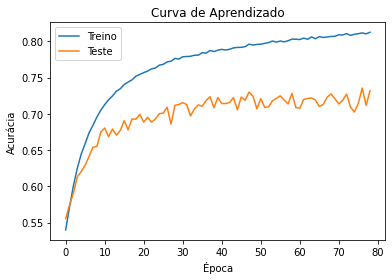

In [47]:
predictions = []
  
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', 'Precision', 'Recall'])




early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
# history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)



# Faz a predição utilizando os dados de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo no conjunto de treinamento e conjunto de teste
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy on training set:', train_acc)
print('Accuracy on test set:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# save model .h5
model.save('model_redeht.h5')